In [1]:
# ---------- Setup ----------
# Run in Google Colab (first cell)
!pip install -q scikit-learn matplotlib seaborn pandas joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib

sns.set(style="whitegrid")


In [2]:
# ---------- 1) Create synthetic dataset (includes categorical + missing + outliers) ----------
np.random.seed(42)
n = 200
data = {
    'Area': np.random.normal(1500, 400, n).astype(int),                 # in sq.ft
    'Bedrooms': np.random.choice([1,2,3,4], size=n, p=[0.1,0.4,0.35,0.15]),
    'Age': np.random.randint(0, 30, n),
    'Location': np.random.choice(['A', 'B', 'C'], n, p=[0.4,0.35,0.25]),
    'Has_Garage': np.random.choice(['Yes','No'], n, p=[0.6,0.4])
}

df = pd.DataFrame(data)
# base price formula + noise
df['Price'] = (df['Area'] * 120) + (df['Bedrooms'] * 5000) - (df['Age'] * 300) + \
              df['Location'].map({'A':20000,'B':10000,'C':0}) + \
              df['Has_Garage'].map({'Yes':5000,'No':0}) + np.random.normal(0, 15000, n)

# Introduce missing values randomly
for col in ['Area','Age','Has_Garage']:
    df.loc[df.sample(frac=0.05, random_state=1).index, col] = np.nan

# Introduce some outliers in Area and Price
df.loc[df.sample(frac=0.02, random_state=2).index, 'Area'] = df['Area'] * 3
df.loc[df.sample(frac=0.02, random_state=3).index, 'Price'] = df['Price'] * 3

df.head()


,Area,Bedrooms,Age,Location,Has_Garage,Price
0,1698.0,4,29.0,A,Yes,227184.633297
1,1444.0,3,24.0,B,Yes,206584.648191
2,1759.0,3,27.0,C,No,209345.432606
3,2109.0,3,16.0,C,Yes,270110.147220
4,NaN,2,NaN,A,NaN,234921.268074


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        190 non-null    float64
 1   Bedrooms    200 non-null    int64  
 2   Age         190 non-null    float64
 3   Location    200 non-null    object 
 4   Has_Garage  190 non-null    object 
 5   Price       200 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 9.5+ KB
None


,Area,Bedrooms,Age,Price
count,190.000000,200.00000,190.000000,200.000000
mean,1522.421053,2.50000,14.431579,212466.521988
std,468.947873,0.91333,8.831345,72290.336686
min,452.000000,1.00000,0.000000,56077.888499
25%,1221.000000,2.00000,6.250000,176675.815721
50%,1527.000000,3.00000,15.000000,201316.045446
75%,1729.750000,3.00000,21.000000,239571.894677
max,4572.000000,4.00000,29.000000,717674.326926


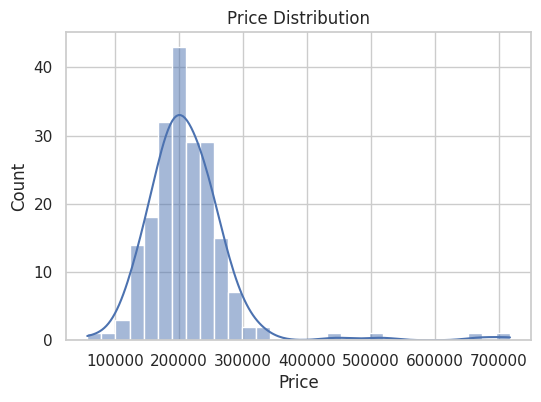

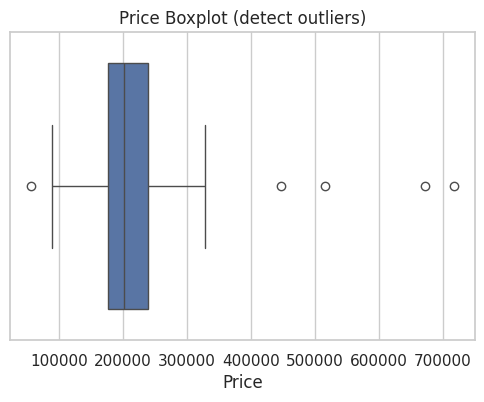

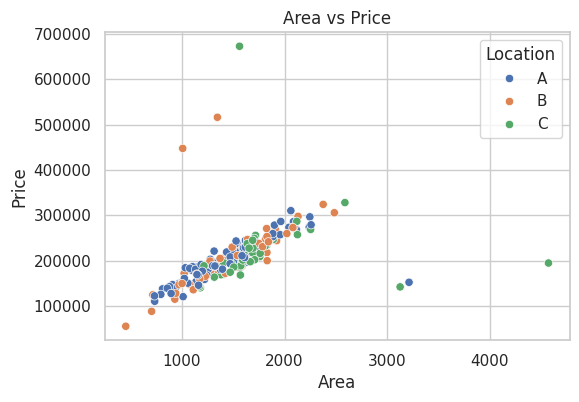

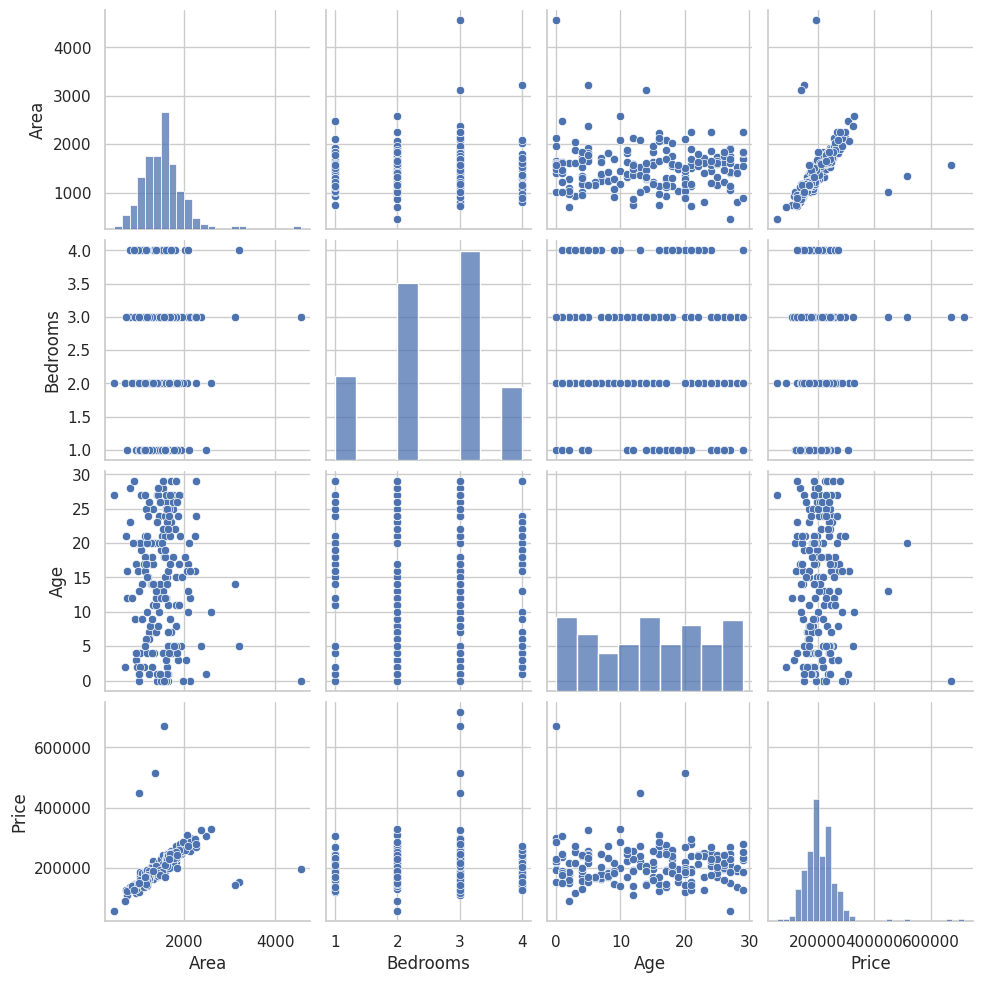

In [3]:
# ---------- 2) EDA & Visualization ----------
print(df.info())
display(df.describe())

# Visuals
plt.figure(figsize=(6,4)); sns.histplot(df['Price'], bins=30, kde=True); plt.title('Price Distribution'); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x=df['Price']); plt.title('Price Boxplot (detect outliers)'); plt.show()
plt.figure(figsize=(6,4)); sns.scatterplot(x='Area', y='Price', hue='Location', data=df); plt.title('Area vs Price'); plt.show()
sns.pairplot(df.select_dtypes(include=[np.number])); plt.show()


In [4]:
# ---------- 3) Missing Values ----------
print("Missing values:\n", df.isnull().sum())

# Strategy:
# - Numeric: SimpleImputer (median)
# - Categorical: SimpleImputer (most_frequent)
num_cols = ['Area','Bedrooms','Age']
cat_cols = ['Location','Has_Garage']

num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

df[num_cols] = num_imputer.fit_transform(df[num_cols])
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

print("After imputation:\n", df.isnull().sum())


Missing values:
 Area          10
Bedrooms       0
Age           10
Location       0
Has_Garage    10
Price          0
dtype: int64
After imputation:
 Area          0
Bedrooms      0
Age           0
Location      0
Has_Garage    0
Price         0
dtype: int64


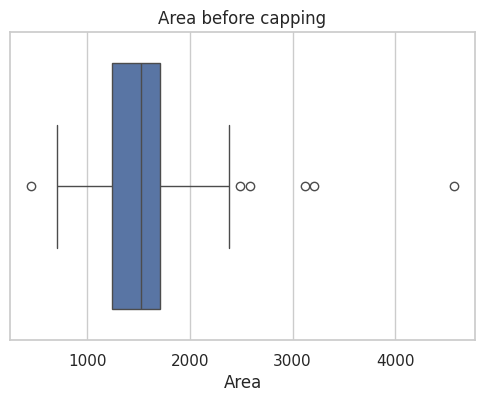

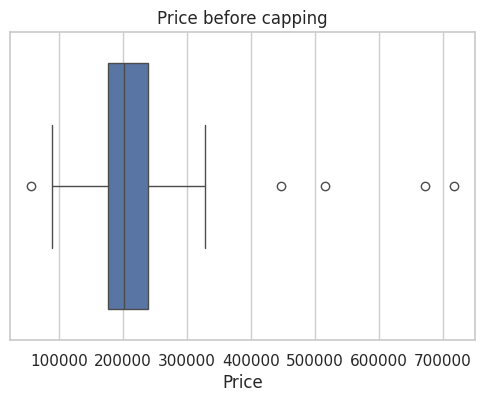

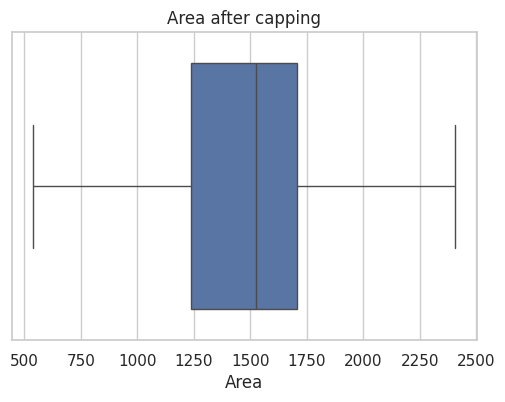

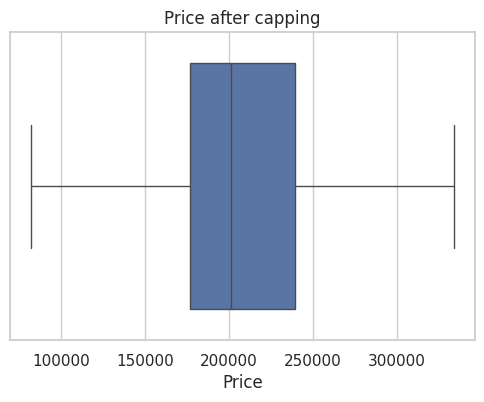

In [5]:
# ---------- 4) Outlier Detection & Handling (IQR + capping) ----------
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    return series.apply(lambda x: upper if x>upper else (lower if x<lower else x))

# Visual before
plt.figure(figsize=(6,4)); sns.boxplot(x=df['Area']); plt.title('Area before capping'); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x=df['Price']); plt.title('Price before capping'); plt.show()

# Cap numeric columns (but do NOT cap target Price aggressively; keep mild cap)
df['Area'] = cap_outliers(df['Area'])
df['Price'] = cap_outliers(df['Price'])

# Visual after
plt.figure(figsize=(6,4)); sns.boxplot(x=df['Area']); plt.title('Area after capping'); plt.show()
plt.figure(figsize=(6,4)); sns.boxplot(x=df['Price']); plt.title('Price after capping'); plt.show()


In [6]:
# ---------- 5) Feature Engineering ----------
# Example: Price per sqft
df['Price_per_sqft'] = df['Price'] / df['Area']

# Encode boolean Has_Garage to 0/1 (simple)
df['Has_Garage_Flag'] = df['Has_Garage'].map({'Yes':1,'No':0})

df.head()


,Area,Bedrooms,Age,Location,Has_Garage,Price,Price_per_sqft,Has_Garage_Flag
0,1698.0,4.0,29.0,A,Yes,227184.633297,133.795426,1
1,1444.0,3.0,24.0,B,Yes,206584.648191,143.064161,1
2,1759.0,3.0,27.0,C,No,209345.432606,119.013890,0
3,2109.0,3.0,16.0,C,Yes,270110.147220,128.074987,1
4,1527.0,2.0,15.0,A,Yes,234921.268074,153.844969,1


In [12]:
# ---------- 6) Prepare pipeline: Encoding + Scaling ----------
X = df[['Area','Bedrooms','Age','Location','Has_Garage_Flag','Price_per_sqft']]
y = df['Price']

# We will one-hot encode Location, scale numeric features
numeric_features = ['Area','Bedrooms','Age','Price_per_sqft', 'Has_Garage_Flag']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_features = ['Location']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [8]:
# ---------- 7) Train/Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
# ---------- 8) Model Training & Comparison ----------
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = {
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
        'R2': r2_score(y_test, y_pred)
    }
    print(f"{name} -> R2: {results[name]['R2']:.3f}, MAE: {results[name]['MAE']:.2f}")


LinearRegression -> R2: 0.910, MAE: 5014.74
Ridge -> R2: 0.910, MAE: 5147.43
DecisionTree -> R2: 0.902, MAE: 9385.39
RandomForest -> R2: 0.963, MAE: 5637.57


In [10]:
# ---------- 9) Cross-validation (example for RandomForest) ----------
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor), ('model', RandomForestRegressor(n_estimators=100, random_state=42))])
cv_scores = cross_val_score(pipe_rf, X, y, cv=5, scoring='r2')
print("RandomForest CV R2 scores:", cv_scores)
print("Mean CV R2:", cv_scores.mean())


RandomForest CV R2 scores: [0.96587121 0.84193423 0.93749737 0.61061847 0.81767034]
Mean CV R2: 0.834718325954445


num__Area              0.721248
num__Price_per_sqft    0.266136
num__Age               0.007615
num__Bedrooms          0.002852
cat__Location_C        0.001132
cat__Location_B        0.001016
dtype: float64


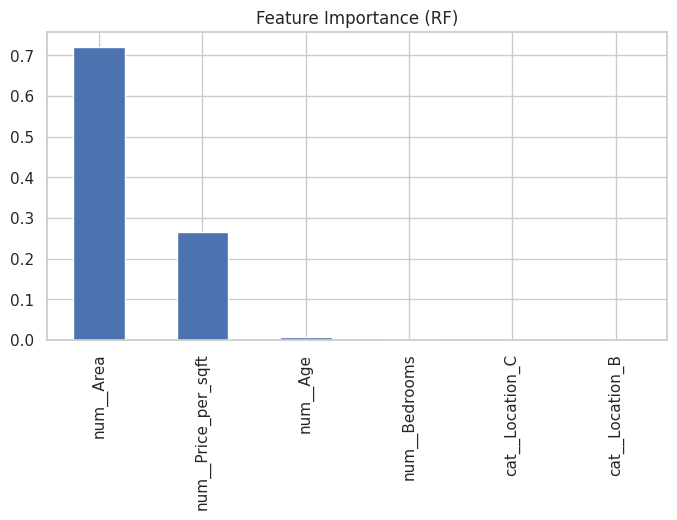

In [14]:
# ---------- 10) Feature importance (for RandomForest) ----------
pipe_rf.fit(X_train, y_train)
# get transformed feature names directly from the preprocessor
feature_names = pipe_rf.named_steps['preprocessor'].get_feature_names_out()

# fetch importance
importances = pipe_rf.named_steps['model'].feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(fi)
fi.plot(kind='bar', figsize=(8,4)); plt.title('Feature Importance (RF)'); plt.show()

In [15]:
# ---------- 11) Save best model ----------
# Suppose RandomForest was best:
best_pipeline = pipe_rf
joblib.dump(best_pipeline, 'house_price_rf_pipeline.joblib')
print("Saved model: house_price_rf_pipeline.joblib")


Saved model: house_price_rf_pipeline.joblib
